In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision.transforms import v2
import matplotlib.pyplot as plt

from utils.dataset_stats import get_mean_std, get_min_max_sizes, summarize_stats


Is grayscale? True
Image shape: torch.Size([1, 224, 224])
Image values: Image([[[0.1451, 0.1451, 0.1451,  ..., 0.4078, 0.4549, 0.5059],
        [0.1098, 0.1098, 0.1098,  ..., 0.3490, 0.4196, 0.4941],
        [0.0824, 0.0824, 0.0824,  ..., 0.2784, 0.3804, 0.4745],
        ...,
        [0.0118, 0.0118, 0.0078,  ..., 0.9451, 0.9529, 0.9608],
        [0.0118, 0.0118, 0.0078,  ..., 0.9451, 0.9490, 0.9529],
        [0.0118, 0.0118, 0.0078,  ..., 0.9333, 0.9333, 0.9333]]], )


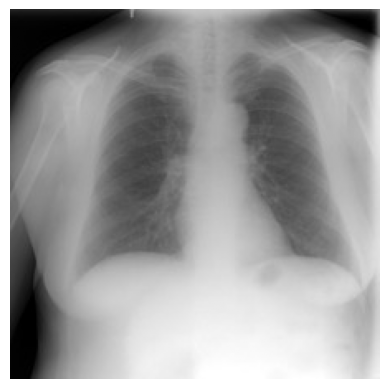

In [3]:
folder = Path("data") / "chestxrays" / "train" / "healthy"
img = Image.open(folder / "h000.jpg")

# Detect if grayscale (mode 'L') or RGB (mode 'RGB')
print(f"Is grayscale? {img.mode == 'L'}")

to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
img_tensor = to_tensor(img)
print(f"Image shape: {img_tensor.shape}")
print(f"Image values: {img_tensor}")

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


In [4]:
class XRayDataset(Dataset):
    def __init__(self, folder: str, is_train: bool, transform: callable = v2.ToDtype(torch.float32, scale=True)) -> None:
        self.data = []    
        self.all_grayscale = True 
        self.transform = transform   
        
        folder_path = Path(folder) / "chestxrays" / ("train" if is_train else "test") 
        
        self.__read_images_from_folder(folder_path / "healthy", is_healty=True)
        self.__read_images_from_folder(folder_path / "tb", is_healty=False)
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img, label = self.data[idx]
        img = self.transform(img)

        return (img, label)
    
    def __read_images_from_folder(self, folder_path: Path, is_healty: bool) -> None:  
        to_image = v2.ToImage()              
        image_paths = list(folder_path.glob("*.jpg"))  # All JPG files        
        label = 0 if is_healty else 1

        for path in image_paths:
            img = Image.open(path)

            if img.mode != 'L':
                self.all_grayscale = False
                img = img.convert('L')
            transformed_img = to_image(img)                        
            self.data.append((transformed_img, label))
            img.close()


In [5]:
training_data = XRayDataset(folder="data", is_train=True)
test_data = XRayDataset(folder="data", is_train=False)


In [6]:
print(summarize_stats(training_data))
print(summarize_stats(test_data))

Number of elements: 302
Minimum height and width: (224, 224), Maximum height and width: (224, 224)
Mean: tensor([0.5707]), standard deviation: tensor([0.2485])

Number of elements: 100
Minimum height and width: (224, 220), Maximum height and width: (224, 224)
Mean: tensor([0.6687]), standard deviation: tensor([0.2556])



In [7]:
training_mean, training_std = get_mean_std(training_data)
training_transforms = v2.Compose([v2.RandomRotation(degrees=5),
                                  v2.RandomHorizontalFlip(),   
                                  v2.GaussianBlur(kernel_size=5, sigma=1),                                
                                  v2.ToDtype(torch.float32, scale=True),                                 
                                  v2.Normalize(mean=training_mean, std=training_std)]) 

In [8]:
training_data = XRayDataset(folder="data", is_train=True, transform=training_transforms)

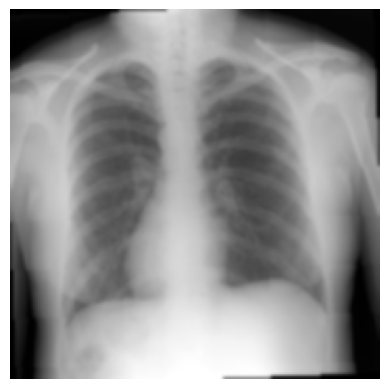

In [9]:
def to_pic(img_tensor: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    img = img_tensor.clone()
    img.mul_(std).add_(mean)
    return img.permute(1, 2, 0)

img = to_pic(training_data[0][0], training_mean, training_std)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [10]:
a = torch.rand(1, 224, 224)
conv = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=7, stride=2, padding=3)
b = conv(a)

print(b.shape)

torch.Size([5, 112, 112])
